In [1]:
import matplotlib.pyplot as plt
from brian2 import *
from params import import_parameters
from typing import List, Tuple
plt.rcParams['figure.figsize'] = (14, 4)
plt.rcParams['figure.dpi'] = 200

# Simple TDE

In [3]:
# network size
neurons_n = 1
input_n = 1
# network parameters
tau_tde = 10 * ms
tau_faci = 50 * ms
# tau_faci = 10 * ms
tau_trig = 10 * ms
# tau_trig = 1 * ms
vthr_tde = 20 * mV
refr_tde = 0.1 * us
trig_thr = 0.2 * pA
# trig_thr = 5 * pA
gain_trig = 0.1
gain_faci = 1 * pA
# gain_faci = 10 * pA

In [4]:
input_trig = PoissonGroup(input_n, rates=[5*Hz])
input_faci = PoissonGroup(input_n, rates=[10*Hz])
# faci_spike = 10*ms
# delay = 1*ms
# input_faci = SpikeGeneratorGroup(1, [0], [faci_spike])
# input_trig = SpikeGeneratorGroup(1, [0], [faci_spike + delay])

tde_model = Equations('''dv/dt = -v/(tau_tde) + I_trig/(0.01*pF) : volt
                        dI_trig/dt = -I_trig/tau_trig : amp
                        dI_faci/dt = -I_faci/tau_faci : amp''')
tde = NeuronGroup(neurons_n*input_n, model=tde_model, method='euler',
                            threshold='v > vthr_tde',
                            refractory='refr_tde',
                            reset='v = 0*mV')

syn_trig = Synapses(input_trig, tde, on_pre='I_trig = gain_trig * int(I_faci > trig_thr) * I_faci')
syn_trig.connect('i == j')

syn_faci = Synapses(input_faci, tde, on_pre='I_faci = gain_faci')
syn_faci.connect('i == j')

mon_input_trig = SpikeMonitor(input_trig)
mon_input_faci = SpikeMonitor(input_faci)
mon_tde = SpikeMonitor(tde)
vmon_tde = StateMonitor(tde, True, True)

run(5*second)

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


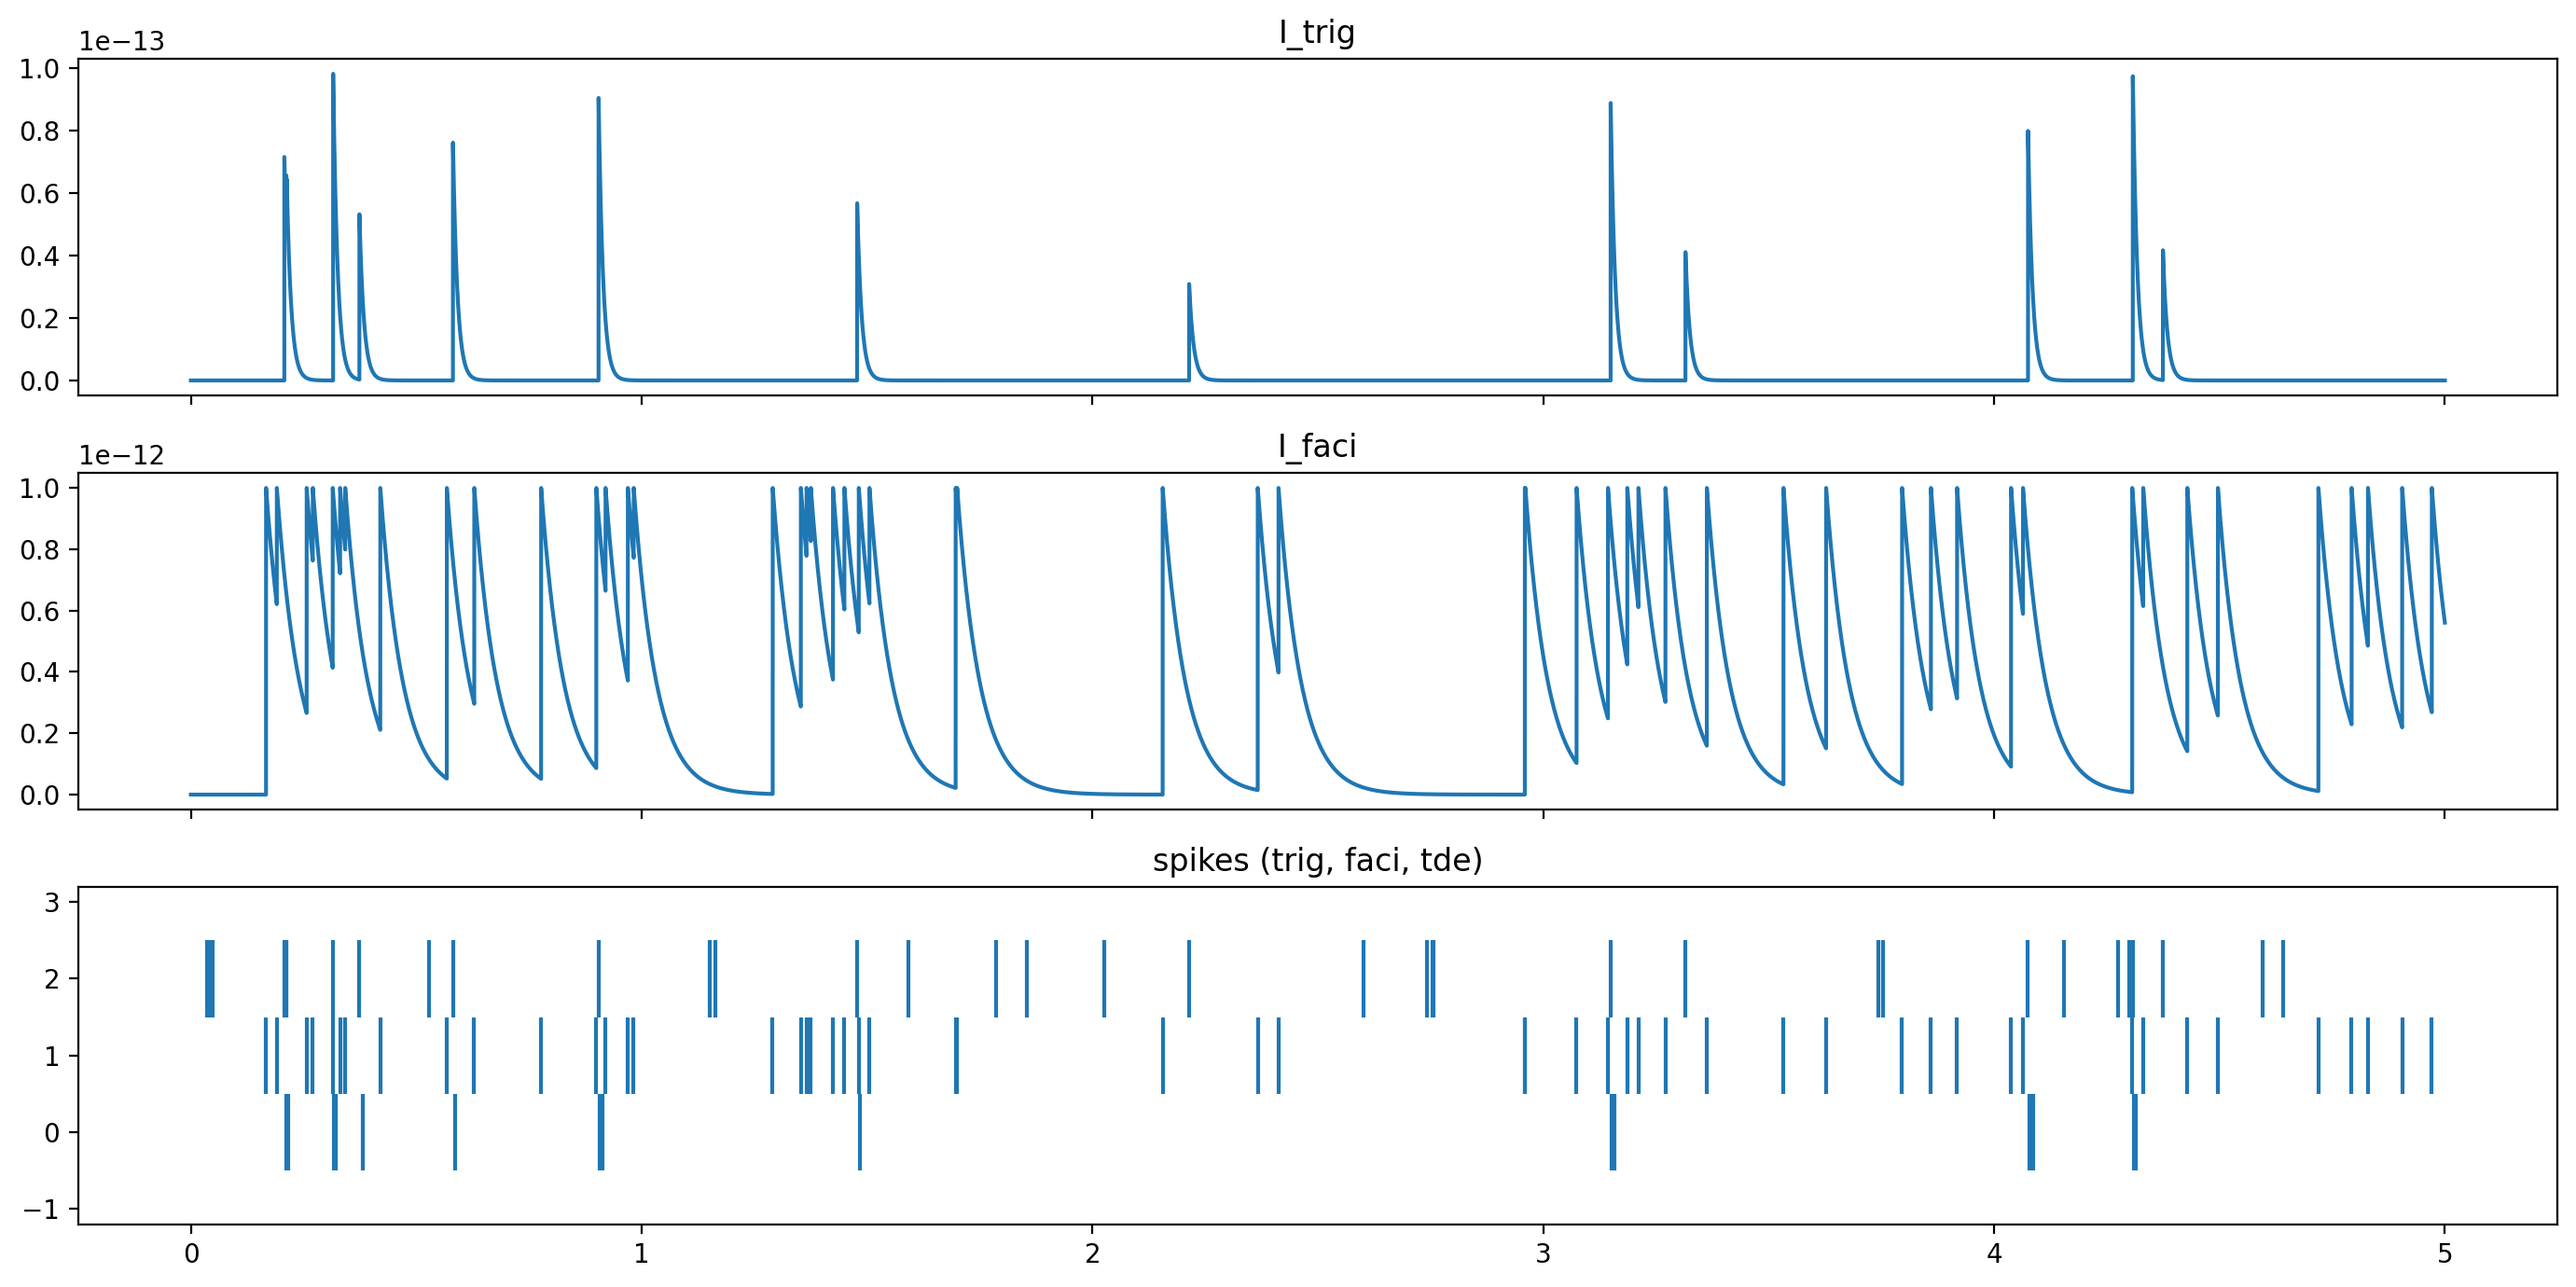

In [5]:
def plot(ax, mon, s):
    ax.set_title(s)
    ax.plot(mon.t, getattr(mon, s)[0])

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14,7), dpi=200, sharex=True)
plot(axs[0], vmon_tde, 'I_trig')
plot(axs[1], vmon_tde, 'I_faci')
ax = axs[2]
ax.set_title('spikes (trig, faci, tde)')
ax.eventplot([mon_input_trig.t, mon_input_faci.t, mon_tde.t], lineoffsets=[2,1,0])
plt.tight_layout()

# Simple oscillator

In [11]:
# network size
n_neurons = 10

# oscillator parameters
tau_osc = 10 * ms
tau_osc_exc = 0.1 * ms
tau_osc_inh = 0.1 * ms
refr_osc = 0.001 * ms
vthr_osc = 10 * mV
I_osc_min = 0.012 * pA
I_osc_step = 0.002 * pA

In [13]:
oscillator_model = Equations('''dv/dt = -v/(tau_osc) + (I + Ie - Ii)/(0.01*pF): volt
                                I : amp
                                dIe/dt = -Ie/(tau_osc_exc) : amp
                                dIi/dt = -Ii/(tau_osc_inh) : amp
                                ''')
oscillator_neuron = NeuronGroup(n_neurons, 
                                model=oscillator_model, 
                                method='euler', 
                                threshold='v > vthr_osc',
                                refractory='refr_osc',
                                reset='v = 0*mV')

for idx in range(n_neurons):
    oscillator_neuron.I[idx] = I_osc_min + idx * I_osc_step

mon_osc = SpikeMonitor(oscillator_neuron)

run(1*second)

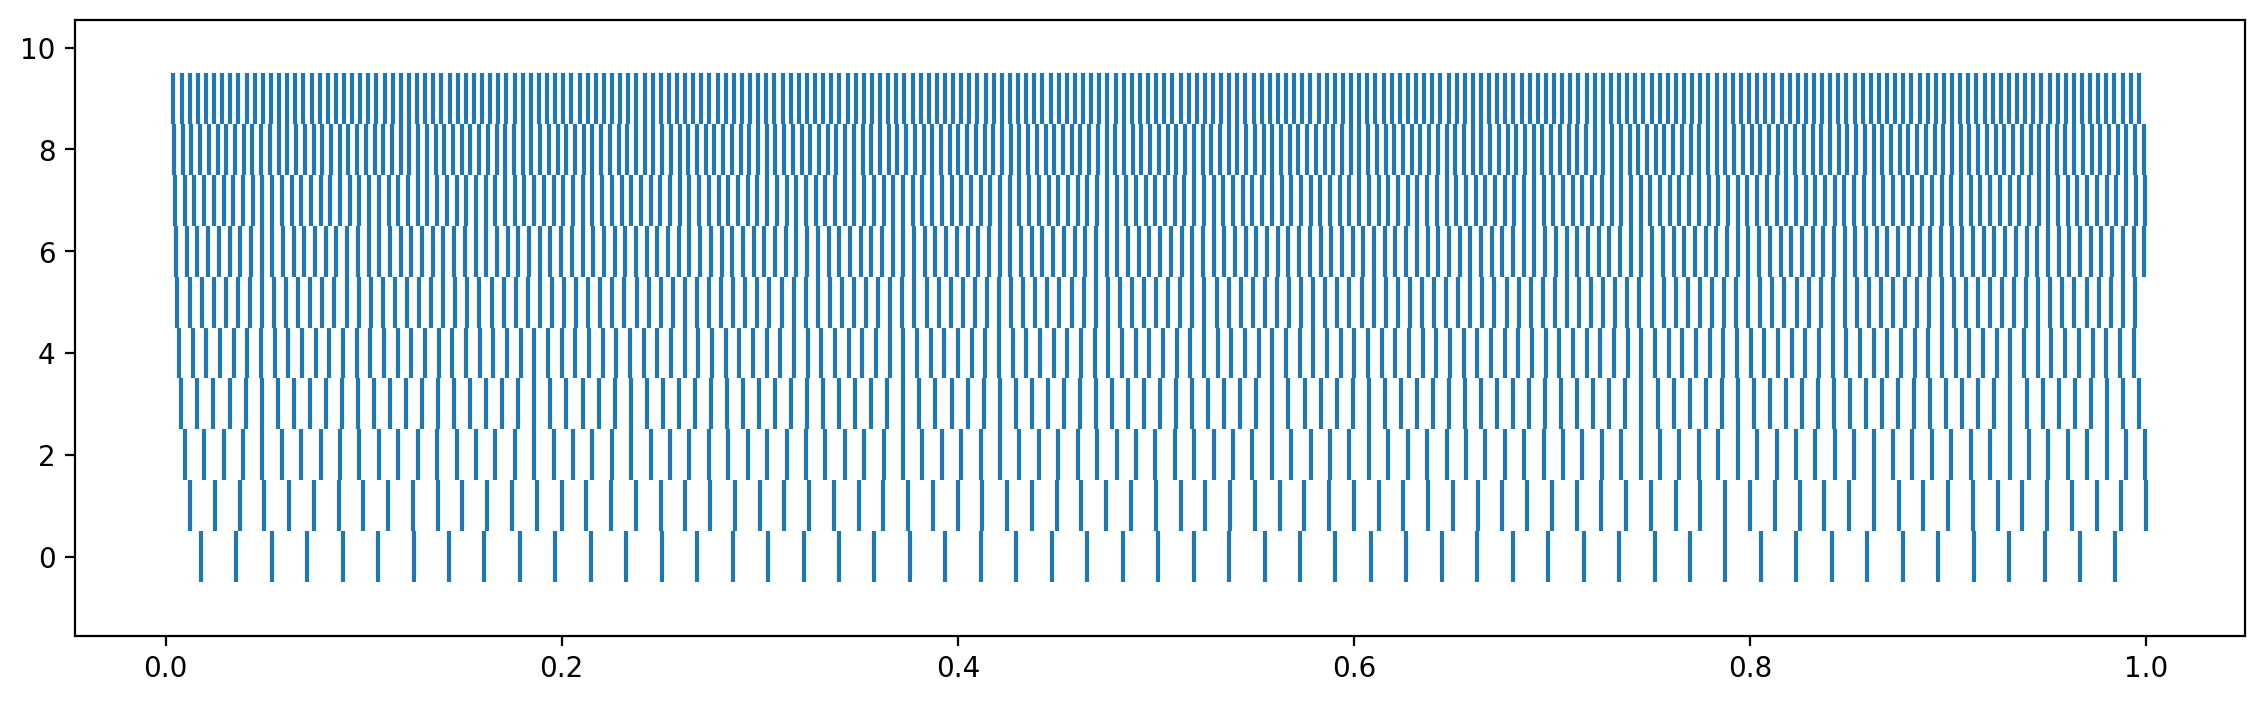

In [24]:
_, ax = plt.subplots(figsize=(14,4), dpi=200)
for idx in range(n_neurons):
    ax.eventplot(mon_osc.t[mon_osc.i == idx], lineoffsets=idx)

# Connect oscillator with TDE

In [2]:
def generate_input(frequencies: List[float], duration: float) -> Tuple[np.array, np.array]:
    """Generate input spike sequence with given frequencies.

    @param frequencies: list of spike frequencies (in Hz)
    @param duration: duration of spike sequences (in seconds)

    @returns t: numpy array with spike times
    @returns i: numpy array with neuron indices (corresponding to t)
    """
    assert isinstance(duration, float), 'type error: duration should be float (in seconds)'
    assert isinstance(frequencies[0], float), 'type error: frequencies should be float (in Hz)'
    # generate timestamps of spikes for all given frequencies
    timestamps = [np.arange(0, duration, 1. / freq) for freq in frequencies]
    # make neuron indices from timestamp array
    idxs = [[idx] * arr.shape[0] for idx, arr in enumerate(timestamps)]
    # flatten into arrays and return
    return np.concatenate(timestamps) * second, np.concatenate(idxs)

In [3]:
def generate_NMDA_matrix(input_neuron, tde_neuron):
    """Create connection matrix mapping input to TDE, where each input neuron is mapped
    to a population of `n_neurons` tde_neurons (i.e. a block diagonal matrix with blocks
    of one-valued row vectors). Implemented using the Kronecker product.

    @param input_neuron: shape (n_inputs)
    @param tde_neuron: shape (n_inputs * n_neurons)

    Example: n_inputs=2, n_neurons=3 -> [[1,1,1,0,0,0] [0,0,0,1,1,1]]
    """
    n_neurons = len(tde_neuron) // len(input_neuron)
    return np.kron(np.eye(len(input_neuron), dtype=int), np.array([[1] * n_neurons]))

In [4]:
def make_oscillator(n_neurons, n_inputs, I_osc_min, I_osc_step) -> NeuronGroup:
    """Make oscillator - dependencies need to be in scope when calling `run`.

    @param n_neurons: number of oscillators
    @param n_inputs: number of neurons per oscillator

    @depend tau_osc
    @depend tau_osc_exc
    @depend tau_osc_inh
    @depend vthr_osc
    @depend refr_osc

    @returns oscillator_neuron: NeuronGroup
    """
    oscillator_model = Equations('''dv/dt = -v/(tau_osc) + (I + Ie - Ii)/(0.01*pF): volt
                                    I : amp
                                    dIe/dt = -Ie/(tau_osc_exc) : amp
                                    dIi/dt = -Ii/(tau_osc_inh) : amp
                                    ''')
    oscillator_neuron = NeuronGroup(n_neurons*n_inputs, 
                                    model=oscillator_model, 
                                    method='euler', 
                                    threshold='v > vthr_osc',
                                    refractory='refr_osc',
                                    reset='v = 0*mV')

    # feed constant current into oscillator neuron to spike at constant rate
    for input_idx in range(n_inputs):
        for neuron_idx in range(n_neurons):
            idx = input_idx * n_neurons + neuron_idx
            oscillator_neuron.I[idx] = I_osc_min + neuron_idx * I_osc_step

    return oscillator_neuron

In [5]:
def test_oscillator(n_neurons, n_inputs, I_osc_min, I_osc_step, duration=1. * second) -> List[int]:
    oscillator_neuron = make_oscillator(n_neurons=n_neurons, n_inputs=n_inputs,
                                        I_osc_min=I_osc_min, I_osc_step=I_osc_step)
    osc_spikes = SpikeMonitor(oscillator_neuron)
    run(duration)
    osc_freqs = []
    for i in range(n_neurons*n_inputs):
        spikes = osc_spikes.t[osc_spikes.i == i]
        osc_freqs.append(spikes.shape[0])
    return osc_freqs

In [6]:
# TDE parameters
tau_tde = 10 * ms
# tau_faci = 50 * ms
tau_faci = 10 * ms
# tau_trig = 10 * ms
tau_trig = 1 * ms
vthr_tde = 20 * mV
refr_tde = 0.1 * us
# trig_thr = 0.2 * pA
trig_thr = 5 * pA
gain_trig = 0.1
# gain_faci = 1 * pA
gain_faci = 10 * pA

# oscillator parameters
tau_osc = 10 * ms
tau_osc_exc = 0.1 * ms
tau_osc_inh = 0.1 * ms
refr_osc = 0.001 * ms
vthr_osc = 10 * mV
gain_tde_to_osc = 0.1 * pA

# high pass filter parameters
tau_hp = 1 * ms
tau_hp_exc = 0.1 * ms
tau_hp_inh = 0.1 * ms
vthr_hp = 10 * mV
refr_hp = 0.1 * ms
gain_hp = 1 * pA

# winner-takes-all parameters
tau_wta = 1 * ms
tau_wta_exc = 10 * ms
tau_wta_inh = 10 * ms
refr_wta = 1 * us
vthr_wta = 10 * mV
i_wta = 0 * pA
gain_wta = 1 * pA

# input parameters
I_osc_min = 0.012 * pA
I_osc_step = 0.002 * pA


In [7]:
n_neurons = 5
n_inputs = 9
frequencies = [55. + 11. * i for i in range(n_inputs)]

### Test oscillator

In [8]:
osc_freqs = test_oscillator(n_neurons, n_inputs, I_osc_min, I_osc_step, duration=1*second)
print(*tuple(map(lambda f: f'{f}Hz', osc_freqs[:n_inputs])), sep=', ')

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


55Hz, 80Hz, 102Hz, 123Hz, 144Hz, 55Hz, 80Hz, 102Hz, 123Hz


### setup TDE

In [9]:
## inputs
arr_times, arr_neurons = generate_input(frequencies, duration=5.)
input_trig = SpikeGeneratorGroup(n_inputs, arr_neurons, arr_times)

## neuron models

tde_model = Equations('''dv/dt = -v/(tau_tde) + I_trig/(0.01*pF) : volt
                         dI_trig/dt = -I_trig/tau_trig : amp
                         dI_faci/dt = -I_faci/tau_faci : amp''')
tde_neuron = NeuronGroup(n_neurons*n_inputs, 
                         model=tde_model,
                         method='euler',
                         threshold='v > vthr_tde',
                         refractory='refr_tde',
                         reset='v = 0*mV')

oscillator_neuron = make_oscillator(n_neurons, n_inputs, I_osc_min, I_osc_step)

# high pass filters
hp_model = Equations('''dv/dt = -v/(tau_hp) + (I + Ie - Ii)/(0.01*pF): volt
                        I : amp
                        dIe/dt = -Ie/(tau_hp_exc) : amp
                        dIi/dt = -Ii/(tau_hp_inh) : amp''')
hp0 = NeuronGroup(n_neurons*n_inputs, model=hp_model, method='euler', 
                  threshold='v > vthr_hp', refractory='refr_hp',
                  reset='v = 0*mV')
hp1 = NeuronGroup(n_neurons*n_inputs, model=hp_model, method='euler', 
                  threshold='v > vthr_hp', refractory='refr_hp',
                  reset='v = 0*mV')
hp2 = NeuronGroup(n_neurons*n_inputs, model=hp_model, method='euler', 
                  threshold='v > vthr_hp', refractory='refr_hp',
                  reset='v = 0*mV')

wta_model = Equations('''dv/dt = -v/(tau_wta) + (I + Ie - Ii)/(0.01*pF) : volt
                         I : amp
                         dIe/dt = -(Ie)/(tau_wta_exc) : amp
                         dIi/dt = -Ii/(tau_wta_inh) : amp''')
wta = NeuronGroup(n_neurons*n_inputs, model=wta_model, method='euler', 
                  threshold='v > vthr_wta', refractory='refr_wta',
                  reset='v = 0*mV')
wta.I = 'i_wta'

poisson_wta = PoissonGroup(n_inputs, 200 * Hz)

## synapses

# input -> TDE (trigger synapse)
syn_trig_rule = 'I_trig = gain_trig * int(I_faci > trig_thr) * I_faci'
syn_trig = Synapses(input_trig, tde_neuron, on_pre=syn_trig_rule)
connection_matrix = generate_NMDA_matrix(input_trig, tde_neuron)
sources, targets = connection_matrix.nonzero()
print(f'connection input idxs: {sources} to tde idxs: {targets}')
syn_trig.connect(i=sources, j=targets)

# oscillator -> TDE (facilitator synapse)
syn_faci = Synapses(oscillator_neuron, tde_neuron, on_pre='I_faci = gain_faci')  # TODO: += instead?
syn_faci.connect('i == j')

# TDE -> oscillator (feedback synapse)
syn_fb = Synapses(tde_neuron, oscillator_neuron, on_pre='Ie_post += gain_tde_to_osc')
syn_fb.connect('i == j')

# high pass filters
hp0_syn = Synapses(tde_neuron, hp0, on_pre='Ie_post += gain_hp')
hp0_syn.connect('i == j')

hp1_syn = Synapses(hp0, hp1, on_pre='Ie_post += gain_hp')
hp1_syn.connect('i == j')

hp2_syn = Synapses(hp1, hp2, on_pre='Ie_post += gain_hp')
hp2_syn.connect('i == j')

# connect winner-takes-all
wta_syn = Synapses(hp2, wta, on_pre='Ii_post += gain_wta')
wta_syn.connect('i == j')

poisson_wta_syn = Synapses(poisson_wta, wta, on_pre='Ie_post += 10*pA')
connection_matrix = generate_NMDA_matrix(poisson_wta, wta)
sources, targets = connection_matrix.nonzero()
poisson_wta_syn.connect(i = sources, j = targets)

## spike monitors

osc_spikes = SpikeMonitor(oscillator_neuron)
input_trig_spikes = SpikeMonitor(input_trig)
tde_spikes = SpikeMonitor(tde_neuron)
hp2_spikes = SpikeMonitor(hp2)
wta_spikes = SpikeMonitor(wta)
# osc_voltage = StateMonitor(oscillator_neuron, True, True)
# tde_voltage = StateMonitor(tde_neuron, True, True)

## run experiment
duration = 1.
run(duration * second)

connection input idxs: [0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7
 7 7 7 8 8 8 8 8] to tde idxs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]


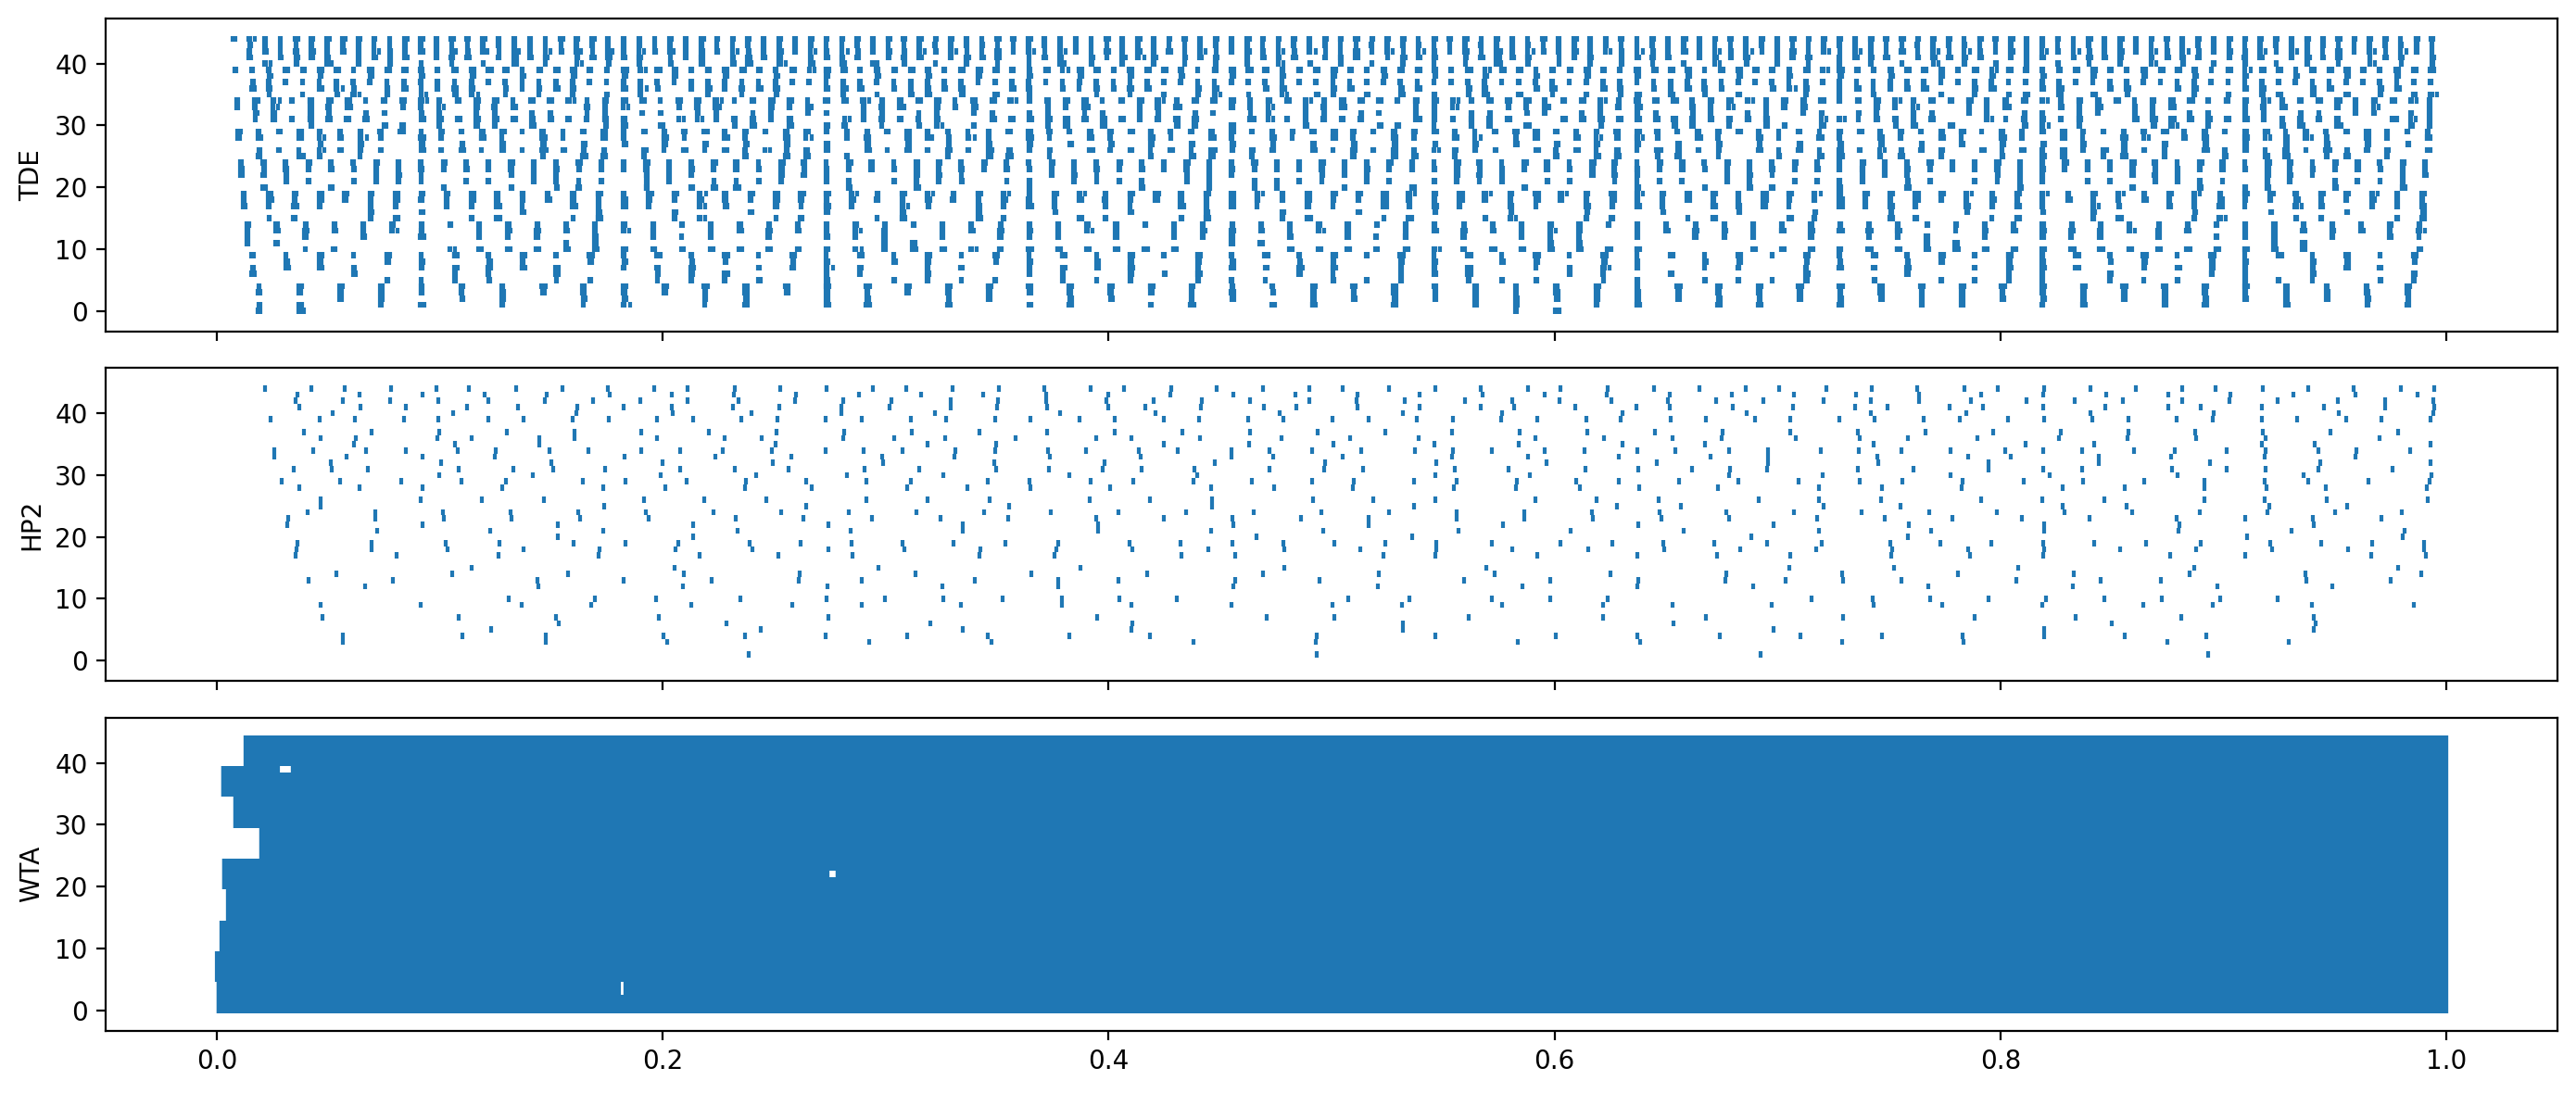

In [10]:
_, axs = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(14,6))
axs[0].set_ylabel('TDE')
axs[0].eventplot(
    positions=[tde_spikes.t[tde_spikes.i == i] for i in range(n_neurons*n_inputs)],
    lineoffsets=list(range(n_neurons*n_inputs))
)
axs[1].set_ylabel('HP2')
axs[1].eventplot(
    positions=[hp2_spikes.t[hp2_spikes.i == i] for i in range(n_neurons*n_inputs)],
    lineoffsets=list(range(n_neurons*n_inputs))
)
axs[2].set_ylabel('WTA')
axs[2].eventplot(
    positions=[wta_spikes.t[wta_spikes.i == i] for i in range(n_neurons*n_inputs)],
    lineoffsets=list(range(n_neurons*n_inputs))
)
plt.tight_layout();

In [15]:
print(f'oscillator frequencies: {osc_freqs[:n_neurons]}')
print(f'input frequencies:      {list(map(int,frequencies))}')
spike_train = hp2_spikes
for idx_input in range(n_inputs):
    hp2_idxs = range(idx_input*n_neurons, (idx_input+1)*n_neurons)
    n_spikes = [spike_train.t[spike_train.i == i].shape[0] for i in hp2_idxs]
    min_idx = n_spikes.index(min(n_spikes))
    # compute differences between input frequency and oscillator frequencies
    diffs = [abs(frequencies[idx_input] - osc_freq) for osc_freq in osc_freqs]
    # compute which oscillator should be selected
    min_idx_true = diffs.index(min(diffs))
    print(f'input {frequencies[idx_input]:3.0f} Hz -> res {osc_freqs[min_idx]:3.0f} Hz (' +\
          f'{osc_freqs[min_idx_true]:3.0f} Hz correct)')

oscillator frequencies: [55, 80, 102, 123, 144]
input frequencies:      [55, 66, 77, 88, 99, 110, 121, 132, 143]
input  55 Hz -> res  55 Hz ( 55 Hz correct)
input  66 Hz -> res 123 Hz ( 55 Hz correct)
input  77 Hz -> res  80 Hz ( 80 Hz correct)
input  88 Hz -> res  80 Hz ( 80 Hz correct)
input  99 Hz -> res  55 Hz (102 Hz correct)
input 110 Hz -> res 102 Hz (102 Hz correct)
input 121 Hz -> res  55 Hz (123 Hz correct)
input 132 Hz -> res 123 Hz (123 Hz correct)
input 143 Hz -> res  55 Hz (144 Hz correct)


## Tests

Testing `generate_input`:

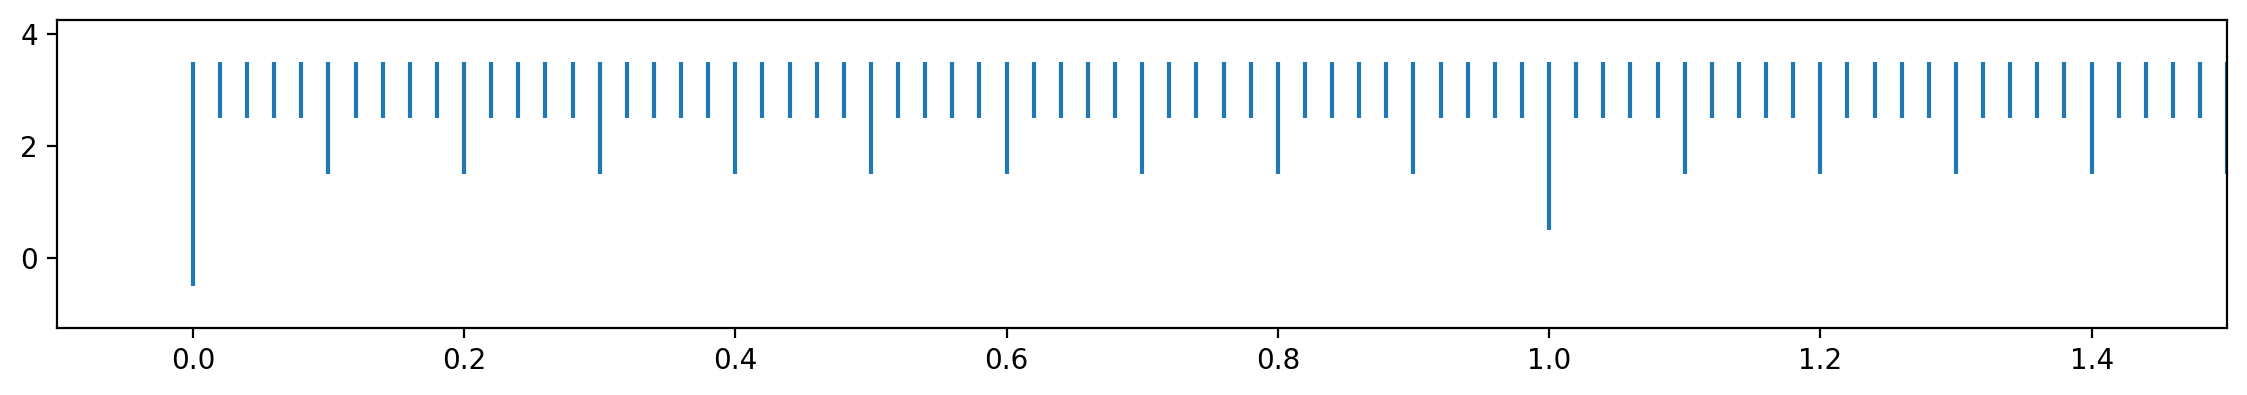

In [62]:
t, i = generate_input([0.1, 1., 10., 50.], 10.5)
_, ax = plt.subplots(figsize=(14, 2), dpi=200)
for idx in range(i.max()+1):
    plt.eventplot(t[i == idx], lineoffsets=idx)
plt.xlim(-0.1, 1.5);